# Clustering Crypto

In [320]:
# Initial imports
import numpy as np
import requests
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import hvplot.pandas
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

### Fetching Cryptocurrency Data

In [321]:
# Use the following endpoint to fetch json data
#url = "https://min-api.cryptocompare.com/data/all/coinlist"

In [322]:
# Create a DataFrame 
# HINT: You will need to use the 'Data' key from the json response, then transpose the DataFrame.

In [323]:
# Alternatively, use the provided csv file:
file_path = Path("Data/crypto_data.csv")

# Create a DataFrame
crypto_df = pd.read_csv(file_path, index_col='Unnamed: 0')
crypto_df.tail()

,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
XBC,BitcoinPlus,Scrypt,True,PoS,1.283270e+05,1000000
DVTC,DivotyCoin,Scrypt,False,PoW/PoS,2.149121e+07,100000000
GIOT,Giotto Coin,Scrypt,False,PoW/PoS,NaN,233100000
OPSC,OpenSourceCoin,SHA-256,False,PoW/PoS,NaN,21000000
PUNK,SteamPunk,PoS,False,PoS,NaN,40000000


### Data Preprocessing

In [324]:
# Keep only necessary columns:
# 'CoinName','Algorithm','IsTrading','ProofType','TotalCoinsMined','TotalCoinSupply'
crypto_df = crypto_df[['CoinName','Algorithm','IsTrading','ProofType','TotalCoinsMined','TotalCoinSupply']]
crypto_df.head()

,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
365,365Coin,X11,True,PoW/PoS,NaN,2300000000
404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
611,SixEleven,SHA-256,True,PoW,NaN,611000
808,808,SHA-256,True,PoW/PoS,0.000000e+00,0


In [325]:
# Keep only cryptocurrencies that are trading
crypto_df_trading = crypto_df[crypto_df['IsTrading']==True]
crypto_df_trading.tail()

,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
SERO,Super Zero,Ethash,True,PoW,NaN,1000000000
UOS,UOS,SHA-256,True,DPoI,NaN,1000000000
BDX,Beldex,CryptoNight,True,PoW,9.802226e+08,1400222610
ZEN,Horizen,Equihash,True,PoW,7.296538e+06,21000000
XBC,BitcoinPlus,Scrypt,True,PoS,1.283270e+05,1000000


In [326]:
# Keep only cryptocurrencies with a working algorithm
working_algo = ['SHA-256','Scrypt','Scrypt Adaptive-N','Scrypt-Jane (Scrypt-Chacha)','X11','X13','X15','Groestl','Quark','Qubit','NeoScrypt','SHA-3 (Keccak)','Blake-256','Ethash','Lyra2REv2','Chacha']
crypto_df_trading = crypto_df_trading[crypto_df_trading['Algorithm'].isin(working_algo)]
crypto_df_trading.head()

,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
365,365Coin,X11,True,PoW/PoS,NaN,2300000000
404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
611,SixEleven,SHA-256,True,PoW,NaN,611000
808,808,SHA-256,True,PoW/PoS,0.000000e+00,0


In [327]:
# Remove the "IsTrading" column
crypto_df_trading = crypto_df_trading.drop(columns=['IsTrading'])
crypto_df_trading.head()

,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,PoW/PoS,4.199995e+01,42
365,365Coin,X11,PoW/PoS,NaN,2300000000
404,404Coin,Scrypt,PoW/PoS,1.055185e+09,532000000
611,SixEleven,SHA-256,PoW,NaN,611000
808,808,SHA-256,PoW/PoS,0.000000e+00,0


In [328]:
# Remove rows with at least 1 null value
crypto_df_trading = crypto_df_trading.dropna()
crypto_df_trading.head()

,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,PoW/PoS,4.199995e+01,42
404,404Coin,Scrypt,PoW/PoS,1.055185e+09,532000000
808,808,SHA-256,PoW/PoS,0.000000e+00,0
1337,EliteCoin,X13,PoW/PoS,2.927942e+10,314159265359
BTC,Bitcoin,SHA-256,PoW,1.792718e+07,21000000


In [329]:
# Remove rows with cryptocurrencies having no coins mined
crypto_df_trading = crypto_df_trading[crypto_df_trading['TotalCoinsMined']>1]
crypto_df_trading.head()

,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,PoW/PoS,4.199995e+01,42
404,404Coin,Scrypt,PoW/PoS,1.055185e+09,532000000
1337,EliteCoin,X13,PoW/PoS,2.927942e+10,314159265359
BTC,Bitcoin,SHA-256,PoW,1.792718e+07,21000000
ETH,Ethereum,Ethash,PoW,1.076842e+08,0


In [330]:
# Drop rows where there are 'N/A' text values
crypto_df_trading[crypto_df_trading['CoinName'] == 'N/A'] #0
crypto_df_trading[crypto_df_trading['Algorithm'] == 'N/A'] #0
crypto_df_trading[crypto_df_trading['ProofType'] == 'N/A'] #0
crypto_df_trading[crypto_df_trading['TotalCoinsMined'] == 'N/A'] #0
crypto_df_trading[crypto_df_trading['TotalCoinSupply'] == 'N/A'] #0

,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply


In [331]:
# Store the 'CoinName'column in its own DataFrame prior to dropping it from crypto_df
coins_name = crypto_df_trading[['CoinName']].copy()
coins_name

,CoinName
42,42 Coin
404,404Coin
1337,EliteCoin
BTC,Bitcoin
ETH,Ethereum
...,...
RCC,Reality Clash
TCH,TigerCash
ZEPH,ZEPHYR
GAP,Gapcoin


In [332]:
# Drop the 'CoinName' column since it's not going to be used on the clustering algorithm
crypto_df_trading['TotalCoinSupply'] = crypto_df_trading['TotalCoinSupply'].astype(np.float64)
crypto_df_trading = crypto_df_trading.drop(columns=['CoinName'])
crypto_df_trading.info()

<class 'pandas.core.frame.DataFrame'>
Index: 364 entries, 42 to XBC
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Algorithm        364 non-null    object 
 1   ProofType        364 non-null    object 
 2   TotalCoinsMined  364 non-null    float64
 3   TotalCoinSupply  364 non-null    float64
dtypes: float64(2), object(2)
memory usage: 14.2+ KB


In [333]:
# Create dummy variables for text features
X = pd.get_dummies(crypto_df_trading)
X.head()

,TotalCoinsMined,TotalCoinSupply,Algorithm_Ethash,Algorithm_Groestl,Algorithm_Lyra2REv2,Algorithm_NeoScrypt,Algorithm_Quark,Algorithm_SHA-256,Algorithm_Scrypt,Algorithm_X11,...,ProofType_PoS/PoW,ProofType_PoS/PoW/PoT,ProofType_PoST,ProofType_PoW,ProofType_PoW and PoS,ProofType_PoW/PoS,ProofType_PoW/PoS,ProofType_PoW/PoW,ProofType_Proof of Trust,ProofType_TPoS
42,4.199995e+01,4.200000e+01,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
404,1.055185e+09,5.320000e+08,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1337,2.927942e+10,3.141593e+11,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
BTC,1.792718e+07,2.100000e+07,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
ETH,1.076842e+08,0.000000e+00,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [334]:
# Standardize data
df_std = StandardScaler().fit_transform(X)
print(df_std[0:5])

[[-0.21158548 -0.20293902 -0.15922347 -0.10540926 -0.10540926 -0.16807316
  -0.19245009 -0.38974188  1.         -0.50085837 -0.22133991 -0.10540926
  -0.05248639 -0.05248639 -0.07432941 -0.4036574  -0.05248639 -0.05248639
  -0.05248639 -0.84197398 -0.05248639  1.19443152 -0.05248639 -0.05248639
  -0.05248639 -0.05248639]
 [-0.14087059 -0.18605159 -0.15922347 -0.10540926 -0.10540926 -0.16807316
  -0.19245009 -0.38974188  1.         -0.50085837 -0.22133991 -0.10540926
  -0.05248639 -0.05248639 -0.07432941 -0.4036574  -0.05248639 -0.05248639
  -0.05248639 -0.84197398 -0.05248639  1.19443152 -0.05248639 -0.05248639
  -0.05248639 -0.05248639]
 [ 1.75062177  9.76950955 -0.15922347 -0.10540926 -0.10540926 -0.16807316
  -0.19245009 -0.38974188 -1.         -0.50085837  4.5179381  -0.10540926
  -0.05248639 -0.05248639 -0.07432941 -0.4036574  -0.05248639 -0.05248639
  -0.05248639 -0.84197398 -0.05248639  1.19443152 -0.05248639 -0.05248639
  -0.05248639 -0.05248639]
 [-0.21038407 -0.20227241 -0.15

### Reducing Dimensions Using PCA

In [335]:
# Use PCA to reduce dimensions to 3 principal components
pca = PCA(n_components=3)

crypto_pca = pca.fit_transform(df_std)

In [336]:
# Create a DataFrame with the principal components data
pcs_df = pd.DataFrame(
    data=crypto_pca, columns=["PC 1", "PC 2", "PC 3"], index=crypto_df_trading.index
)
pcs_df.head()

,PC 1,PC 2,PC 3
42,-0.637561,1.273258,-1.187413
404,-0.619078,1.304384,-1.152145
1337,0.162135,4.839542,5.344538
BTC,0.997291,-1.815344,0.588861
ETH,1.840887,-2.233702,0.321065


### Clustering Crytocurrencies Using K-Means

#### Find the Best Value for `k` Using the Elbow Curve

In [337]:
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(pcs_df)
    inertia.append(km.inertia_)

# Create the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.hvplot.line(x="k", y="inertia", title="Elbow Curve", xticks=k)

:Curve   [k]   (inertia)

Running K-Means with `k=<your best value for k here>`

In [338]:
def get_clusters(k, data):
    # Initialize the K-Means model
    model = KMeans(n_clusters=k, random_state=0)

    # Fit the model
    model.fit(data)

    # Predict clusters
    predictions = model.predict(data)

    # Create return DataFrame with predicted clusters
    data["class"] = model.labels_

    return data

clustered_df = get_clusters(6, pcs_df)
clustered_df = pd.concat([clustered_df,crypto_df_trading], 1)
clustered_df = pd.concat([clustered_df,coins_name],1)
clustered_df

C:\Users\Jay Cao\Anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:17: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only

C:\Users\Jay Cao\Anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:18: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



,PC 1,PC 2,PC 3,class,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply,CoinName
42,-0.637561,1.273258,-1.187413,0,Scrypt,PoW/PoS,4.199995e+01,4.200000e+01,42 Coin
404,-0.619078,1.304384,-1.152145,0,Scrypt,PoW/PoS,1.055185e+09,5.320000e+08,404Coin
1337,0.162135,4.839542,5.344538,4,X13,PoW/PoS,2.927942e+10,3.141593e+11,EliteCoin
BTC,0.997291,-1.815344,0.588861,1,SHA-256,PoW,1.792718e+07,2.100000e+07,Bitcoin
ETH,1.840887,-2.233702,0.321065,1,Ethash,PoW,1.076842e+08,0.000000e+00,Ethereum
...,...,...,...,...,...,...,...,...,...
RCC,1.839839,-2.235483,0.319093,1,Ethash,PoW,2.448794e+07,2.448794e+07,Reality Clash
TCH,-0.468854,-1.228924,1.906529,3,SHA-256,PoS,1.000000e+09,1.000000e+09,TigerCash
ZEPH,-0.267450,-2.430213,2.466055,3,SHA-256,DPoS,2.000000e+09,2.000000e+09,ZEPHYR
GAP,-0.635807,1.276152,-1.183962,0,Scrypt,PoW/PoS,1.493105e+07,2.500000e+08,Gapcoin


### Visualizing Results

#### 3D-Scatter with Clusters

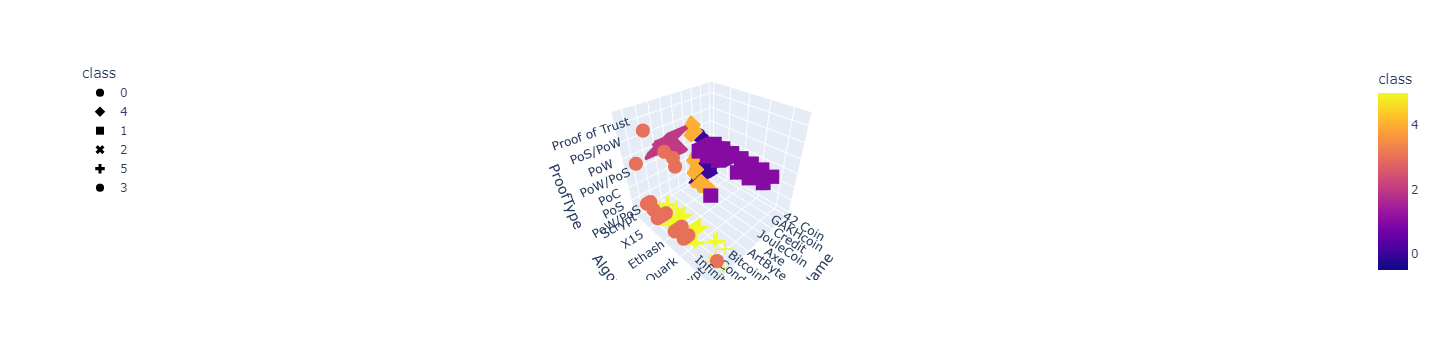

In [339]:
# Create a 3D-Scatter with the PCA data and the clusters
fig = px.scatter_3d(
    clustered_df,
    x="CoinName",
    y="Algorithm",
    z="ProofType",
    color="class",
    symbol="class",
    width=800,
    hover_name="CoinName",
    hover_data=["Algorithm"]
)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()

#### Table of Tradable Cryptocurrencies

In [340]:
# Table with tradable cryptos
clustered_df.hvplot.table(columns=["CoinName", "Algorithm", "ProofType", "TotalCoinSupply", "TotalCoinsMined", "class"], sortable=True, selectable=True)


:Table   [CoinName,Algorithm,ProofType,TotalCoinSupply,TotalCoinsMined,class]

In [341]:
# Print the total number of tradable cryptocurrencies
print(f"Total Number of Tradable Cryptocurrencies are: {len(clustered_df)}.")

Total Number of Tradable Cryptocurrencies are: 364.


#### Scatter Plot with Tradable Cryptocurrencies

In [342]:
# Scale data to create the scatter plot


In [343]:
# Plot the scatter with x="TotalCoinsMined" and y="TotalCoinSupply"
clustered_df.hvplot.scatter(x="TotalCoinsMined", y="TotalCoinSupply", by="class", hover_cols=["CoinName"])

:NdOverlay   [class]
   :Scatter   [TotalCoinsMined]   (TotalCoinSupply,CoinName)